# Single Curve Model

This notebook demonstrates creating a single curve model for flu vaccine uptake.

In [1]:
# Add graphviz to path
import os
os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# External dependency imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import seaborn as sns

# `vaxflux` imports
from vaxflux.data import read_flu_vacc_data
from vaxflux.single_curve_model import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## The Sample Dataset

This notebook uses national flu vaccine uptake from the 2018/19 flu season through the 2023/24 season.

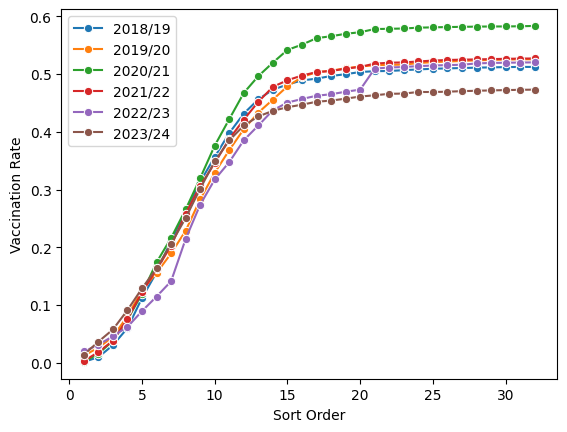

In [2]:
# Read in the dataset and define some constants
vacc_data = read_flu_vacc_data()
national_population = 333.3 # In millions
vacc_data["doses"] = vacc_data["doses"]/national_population

# Plot the data for a quick visual
g = sns.lineplot(
    x=vacc_data['sort_order'],
    y=vacc_data['doses'],
    hue=vacc_data['season'],
    marker='o'
)
handles, labels = g.get_legend_handles_labels()
g.legend(
    handles, 
    ["2018/19", "2019/20", "2020/21", "2021/22", "2022/23", "2023/24"]
)
g.set(xlabel="Sort Order", ylabel="Vaccination Rate")
plt.show(g)

Besides the one odd bump in the 2022/23 flu season, the flu vaccine uptake has a consistent logistic curve shape across seasons. The main difference between seasons is the max uptake.

## An Initial Curve Fit

The first model will be fit using least squares for simplicity and speed of fit. We use the following model,

$$ \frac{du}{dt} = ru\left(1 - \frac{u}{k}\right), $$

which emits the solution

$$ u = \frac{k}{1 - e^{-\left(c_0 k + r t\right)}}, $$

where $c_0$ is some constant.

In [3]:
opt_result = modified_logistic_curve_least_squares(vacc_data["sort_order"], vacc_data["doses"])
for param, estimate in zip(["r", "k", "c0"], opt_result.x):
    print(f"* Estimate for {param} = {estimate:.4f}.")

* Estimate for r = 0.4022.
* Estimate for k = 0.5174.
* Estimate for c0 = 8.3019.


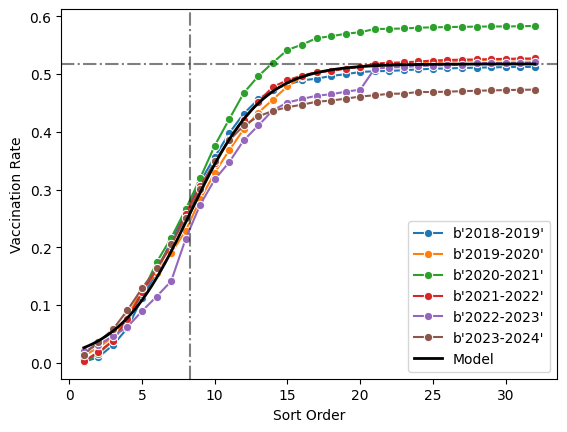

In [4]:
# Quickly create some plot data
sort_order = np.linspace(np.min(vacc_data["sort_order"]), np.max(vacc_data["sort_order"]), 1000)
doses_estimate = modified_logistic_curve(sort_order, *opt_result.x)
_, k_hat, c0_hat = opt_result.x

# Plot the least squares fit for a quick visual
g = sns.lineplot(
    x=vacc_data['sort_order'],
    y=vacc_data['doses'],
    hue=vacc_data['season'],
    marker='o'
)
handles, labels = g.get_legend_handles_labels()
g.legend(
    handles, 
    ["2018/19", "2019/20", "2020/21", "2021/22", "2022/23", "2023/24"]
)
g = sns.lineplot(
    x=sort_order,
    y=doses_estimate,
    linewidth=2,
    label="Model",
    color="black",
    ax=g
)
g.axhline(y=k_hat, color="black", linestyle="-.", alpha=0.5)
g.axvline(x=c0_hat, color="black", linestyle="-.", alpha=0.5)
g.set(xlabel="Sort Order", ylabel="Vaccination Rate")
plt.show(g)

TODO: Discuss this initial fit

## A Bayesian Curve Fit

Using PyMC we'll fit this model using MCMC sampling. For our priors the model will be:

$$ \sigma \sim \mathrm{HalfNormal}(\sigma_\sigma) $$

$$ r \sim \mathcal{N}(0, \sigma_r) $$

$$ k \sim \mathrm{HalfNormal}(\sigma_k) $$

$$ c_0 \sim \mathcal{N}(0, \sigma_{c_0}) $$

And the observations will be drawn from:

$$ y_{\mathrm{obs}} \sim \mathcal{N}(f(r, k, c_0), \sigma) $$

In [5]:
model, trace = modified_logistic_curve_bayes_model(vacc_data["sort_order"], vacc_data["doses"], tune=5000, draws=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [r]
>>Slice: [k]
>>Slice: [c0]
>NUTS: [sigma]


/Users/twillard/Library/Caches/pypoetry/virtualenvs/vaxflux-TxTkjOEN-py3.12/lib/python3.12/site-packages/rich/live.
py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 4 seconds.


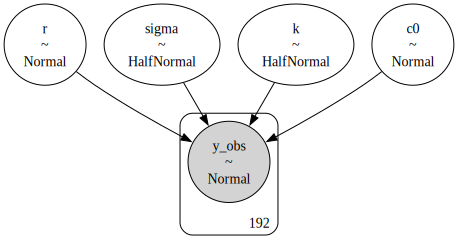

In [6]:
pm.model_to_graphviz(model)

In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,8.302,0.102,8.110,8.492,0.001,0.001,12501.0,13691.0,1.0
k,0.517,0.003,0.511,0.523,0.000,0.000,10692.0,12574.0,1.0
r,0.403,0.015,0.376,0.431,0.000,0.000,13114.0,13576.0,1.0
sigma,0.029,0.002,0.027,0.032,0.000,0.000,9121.0,13453.0,1.0


array([[<Axes: title={'center': 'c0'}>, <Axes: title={'center': 'c0'}>],
       [<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'r'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

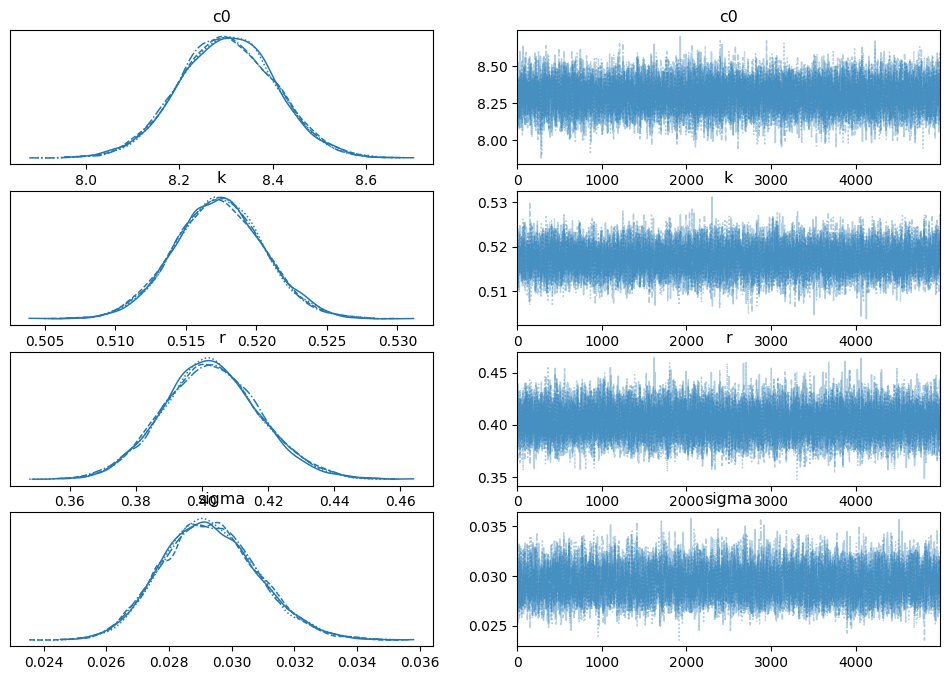

In [8]:
az.plot_trace(trace, kind="trace")

In [9]:
# Time to plot a distribution
stacked = az.extract(trace.posterior)
doses_estimate_dist = np.zeros((stacked.sizes["sample"], len(sort_order)))

for i in range(stacked.sizes["sample"]):
    doses_estimate_dist[i,:] = modified_logistic_curve(sort_order, stacked.r.values[i], stacked.k.values[i], stacked.c0.values[i])

doses_estimate_dist_summary = np.quantile(doses_estimate_dist, [0.005, 0.1, 0.5, 0.9, 0.995], axis=0)

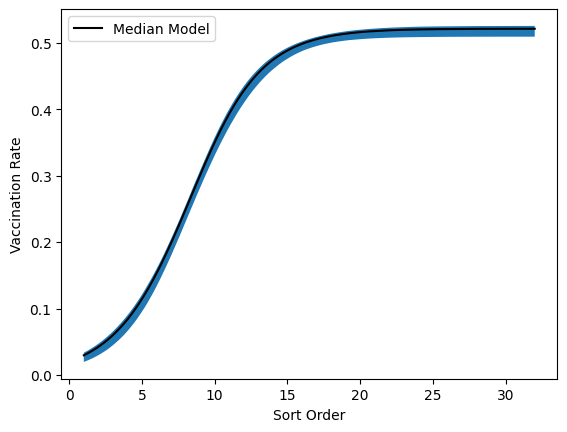

In [10]:
# Plot the bayes fit for a quick visual
g = sns.lineplot(
    x=sort_order,
    y=doses_estimate_dist_summary[3,:],
    label="Median Model",
    color="Black"
)
g.fill_between(sort_order, doses_estimate_dist_summary[0,:], doses_estimate_dist_summary[4,:])
g.set(xlabel="Sort Order", ylabel="Vaccination Rate")
plt.show(g)